# Data Analysis 2025

## Trees and Bagging

### Learning Goals

+ Explain the intuition behind decision trees for classification and regression
+ Identify key components of a decision tree (splitting criteria, nodes, leaves)
+ Train and evaluate decision trees
+ Discuss overfitting and underfitting in decision trees
+ Explain the concept of bagging 
+ Describe how bagging reduces variance and improves model robustness
+ Understand why decision trees are well-suited for bagging
+ Understand how random forests extend bagging with feature randomness
+ Compare decision trees, bagging and random forests in terms of bias-variance tradeoff

# Announcements

+ Clinic 1 is due Monday *late night*.
+ Mid-course evaluation is running. Submit it after the clinic 2 completion. Check canvas/announcements for link. 
+ Pick the content of our meeting on Monday, March 10th. Use wooclap when not in class (https://app.wooclap.com/UMDA?from=event-page)


# Part 1: Decision Trees

We are now going to remind ourselves of *decision trees*.

# Review: Components of A Supervised Machine Learning Problem

At a high level, a supervised machine learning problem has the following structure:

$$ \underbrace{\text{Training Dataset}}_\text{Attributes + Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

# Decision Trees: Intuition

Decision trees are very intuitive classification and regression tools. 

Consider the following [decision tree from the New York Times](https://archive.nytimes.com/www.nytimes.com/imagepages/2008/04/16/us/20080416_OBAMA_GRAPHIC.html), 
which predicts whether a county voted for Obama or Clinton in the 2008 democratic primary. 
<center>
<img src="img/oc-tree.jpeg" width="500">
</center>

Here is another decision tree for the survival of passengers on the titanic.  The figures under the leaves show the probability of survival and the percentage of observations in the leaf.

<center>
<img src="img/titanic_tree.png" width="500">
</center>

The use of a decision tree is very simple. Suppose someone gives you this tree and a new person. In order to predict whether or not the person would have died on the titanic, you ask the following questions, in order:

 * Is the person male? If no, we predict they would have survived. If yes, continue.
 * Is the person older than 9.5 years? If yes, we predict they would have died. If no, continue.
 * Did the person have more than 3 or more siblings? If yes, we predict they would have died. If no, they would have survived.
 
Many of these decisions make intuitive sense: social convention gave women and children preference for rescue. Some, however, are not as obvious: why is having more than 3 siblings or spouses a marker? Could this be a marker for a hidden variable?

## 1.1 Decision Trees with SciKit Learn

Scikit-learn has [a nice decision tree implementation](http://scikit-learn.org/stable/modules/tree.html) which we'll use to learn a tree for the famous Titanic dataset.

We'll consider [a dataset of Titanic passengers](https://www.kaggle.com/c/titanic/) and develop a model to predict whether a particular passenger will survive or not. This is what [the dataset](titanic.csv) looks like:


| PassengerId | *Survived* | Pclass | Name                                                                               | Sex    | Age  | SibSp | Parch | Ticket             | Fare     | Cabin           | Embarked |
|-------------|----------|--------|------------------------------------------------------------------------------------|--------|------|-------|-------|--------------------|----------|-----------------|----------|
| 1           | 0        | 3      | Braund, Mr. Owen Harris                                                            | male   | 22   | 1     | 0     | A/5 21171          | 7.25     |                 | S        |
| 2           | 1        | 1      | Cumings, Mrs. John Bradley (Florence Briggs Thayer)                                | female | 38   | 1     | 0     | PC 17599           | 71.2833  | C85             | C        |
| 3           | 1        | 3      | Heikkinen, Miss. Laina                                                             | female | 26   | 0     | 0     | STON/O2. 3101282   | 7.925    |                 | S        |
| 4           | 1        | 1      | Futrelle, Mrs. Jacques Heath (Lily May Peel)                                       | female | 35   | 1     | 0     | 113803             | 53.1     | C123            | S        |
| 5           | 0        | 3      | Allen, Mr. William Henry                                                           | male   | 35   | 0     | 0     | 373450             | 8.05     |                 | S        |


Here are the variable descriptions for the non-obvious variables:
 * **Survived:**        (0 = No; 1 = Yes)
 * **pclass:**          Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 * **sibsp:**           Number of Siblings/Spouses Aboard
 * **parch:**           Number of Parents/Children Aboard
 * **ticket:**          Ticket Number
 * **fare:**            Passenger Fare
 * **cabin:**           Cabin
 * **embarked:**        Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


We're trying to decide whether a passenger with particular attributes will survive the Titanic disaster, so the `Survived` variable is our **target**, the other columns are the **features**. 

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('fivethirtyeight')

titanic = pd.read_csv("titanic.csv")
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## 1.2 Data cleanup

We need to do some cleanup: 
 * Age has missing values. Let's assume that a person with missing age is of mean age (this is not necessarily a good decision. Why?).
 * Embarked has missing values, we add a dedicated category for unknown embarkation points.
 * We need to convert the categorical values to numerical values. 

In [2]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())

def sex_to_numeric(x):
    if x=='male':
        return 0
    if x=='female':
        return 1
    else:
        return x

titanic["Sex"] = titanic["Sex"].apply(sex_to_numeric)
titanic.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name  Sex   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    0  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0      1      0   
2                             Heikkinen, Miss. Laina    1  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0      1      0   
4                           Allen, Mr. William Henry    0  35.0      0      0   

             Ticket     Fare Cabin Embarked  
0         A/5 21171   7.2500   NaN        S  
1          PC 17599  71.2833   C85        C  
2  STON/O2. 3101282   7.9250   NaN        S  
3            113803  53.1000  C123        S  
4            373450   8.0500   NaN        S

In [3]:
# this will break if run more than once
def embarked_to_numeric(x):
    if x=="S":
        return 0
    if x=="C":
        return 1
    if x=="Q":
        return 2
    else: 
        return 3
    
titanic["Embarked"] = titanic["Embarked"].apply(embarked_to_numeric)
titanic.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name  Sex        Age  SibSp  \
0                            Braund, Mr. Owen Harris    0  22.000000      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.000000      1   
2                             Heikkinen, Miss. Laina    1  26.000000      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.000000      1   
4                           Allen, Mr. William Henry    0  35.000000      0   
5                                   Moran, Mr. James    0  29.699118      0   
6                            McCarthy, Mr. Timothy J    0  54.000000      0   
7                     Palsson, Master. Gosta Leonard    0   2.000000      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)    1  27.000000      0   
9                Nasser, Mrs. Nicholas (Adele Achem)    1  14.000000      1   

   Parch            Ticket     Fare Cabin  Embarked  
0      0         A/5 21171   7.2500   NaN         0  
1      0          PC 17599  71.2833   C85         1  
2      0  STON/O2. 3101282   7.9250   NaN         0  
3      0            113803  53.1000  C123         0  
4      0            373450   8.0500   NaN         0  
5      0            330877   8.4583   NaN         2  
6      0             17463  51.8625   E46         0  
7      1            349909  21.0750   NaN         0  
8      2            347742  11.1333   NaN         0  
9      0            237736  30.0708   NaN         1

Let's work only with the numerical and categorical variables and omit passengerID, Name, Ticket and Cabin. These values could contain some information, but it's hard to make sense of them without more context.

In [4]:
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic = titanic[features]
titanic.head(10)

Survived  Pclass  Sex        Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.000000      1      0   7.2500         0
1         1       1    1  38.000000      1      0  71.2833         1
2         1       3    1  26.000000      0      0   7.9250         0
3         1       1    1  35.000000      1      0  53.1000         0
4         0       3    0  35.000000      0      0   8.0500         0
5         0       3    0  29.699118      0      0   8.4583         2
6         0       1    0  54.000000      0      0  51.8625         0
7         0       3    0   2.000000      3      1  21.0750         0
8         1       3    1  27.000000      0      2  11.1333         0
9         1       2    1  14.000000      1      0  30.0708         1

## 1.3 Exploring the data

Let's take a look at the data:

In [5]:
titanic.describe()

Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413   29.699118    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.002015    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000   29.699118    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   35.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             Fare    Embarked  
count  891.000000  891.000000  
mean    32.204208    0.368126  
std     49.693429    0.647601  
min      0.000000    0.000000  
25%      7.910400    0.000000  
50%     14.454200    0.000000  
75%     31.000000    1.000000  
max    512.329200    3.000000

**Questions:**
+ What percentage of passengers survived? 
+ What percentage of passengers are female?

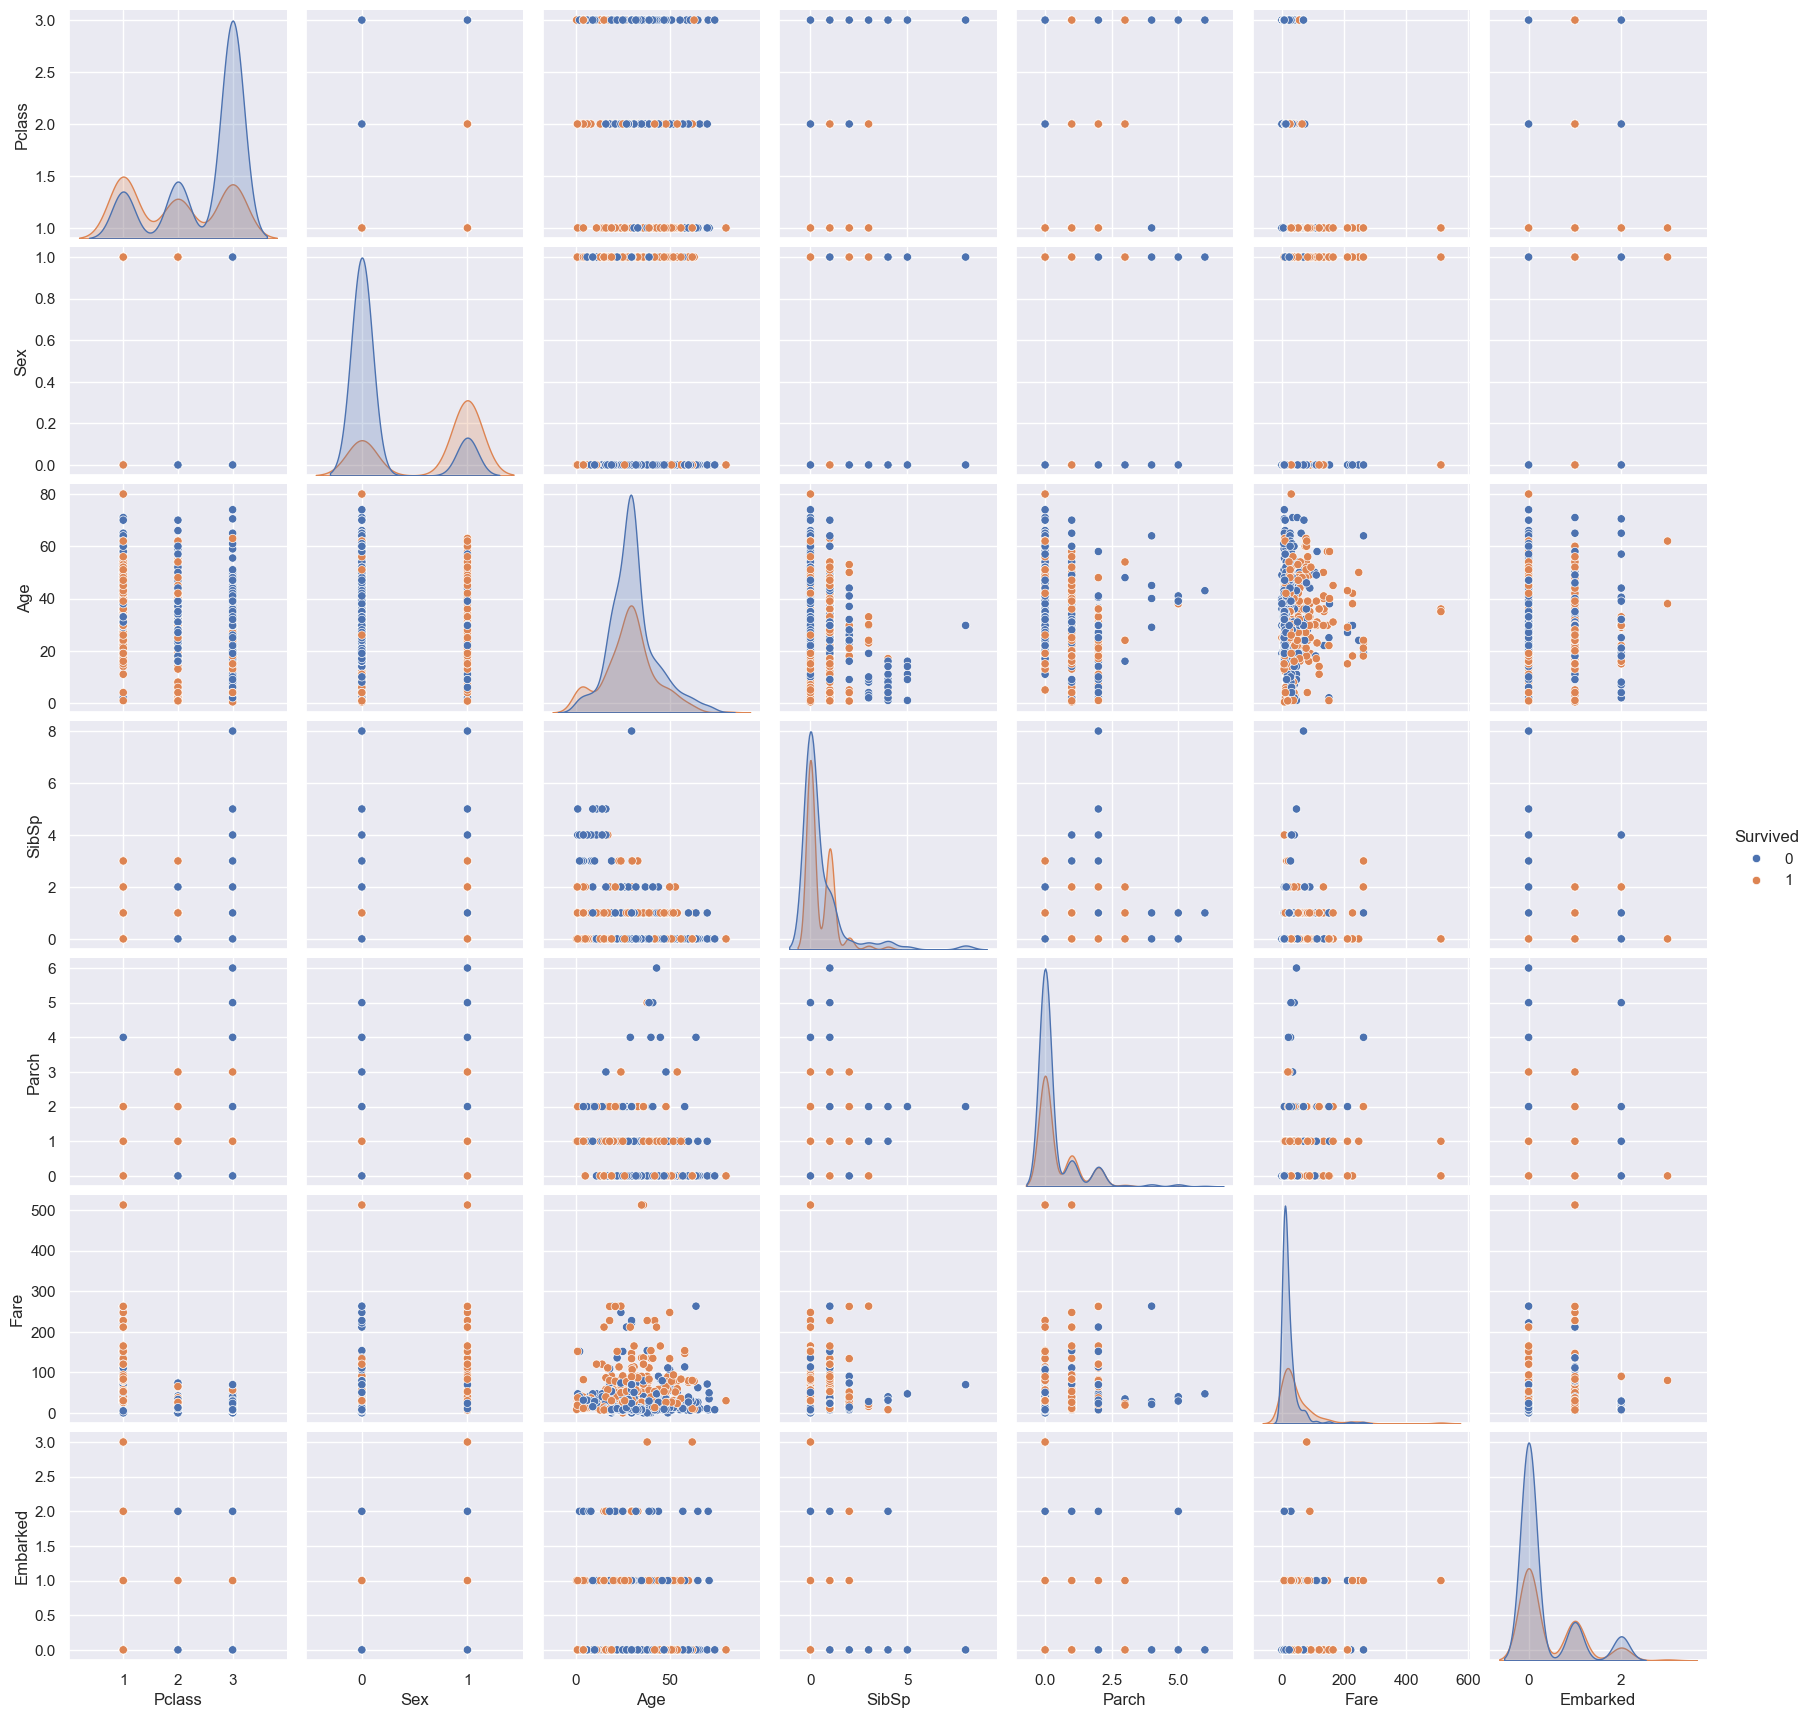

In [6]:
import seaborn as sns
sns.set()
sns.pairplot(titanic, hue="Survived");

## 1.4 Our first tree 

We are using two boilerplate functions below:

+ Split data into training and test set and also select some features
+ Plot decision trees (without getting any weird errors...)

In [7]:
#labels =["Survived", "Perished"]

def splitData(features):
    """Split a subset of the titanic dataset, given by the features, into train and test sets."""
    titanic_predictors = titanic[features].values
    titanic_labels = titanic["Survived"].values

    # Split into training and test sets
    XTrain, XTest, yTrain, yTest = train_test_split(titanic_predictors, titanic_labels, random_state=1, test_size=0.5)
    return XTrain, XTest, yTrain, yTest

In [8]:
from IPython.display import Image, display  
import pydotplus 
from scipy import misc

def renderTree(my_tree, features):
    # hacky solution of writing to files and reading again
    # necessary due to library bugs
    filename = "temp.dot"
    with open(filename, 'w') as f:
        f = tree.export_graphviz(my_tree, 
                                 out_file=f, 
                                 feature_names=features, 
                                 class_names=["Perished", "Survived"],  
                                 filled=True, 
                                 rounded=True,
                                 special_characters=True)
  
    dot_data = ""
    with open(filename, 'r') as f:
        dot_data = f.read()

    graph = pydotplus.graph_from_dot_data(dot_data)
    image_name = "temp.png"
    graph.write_png(image_name)  
    display(Image(filename=image_name))

Now let's look at a decision tree that **ONLY operates on sex**! 

Accuracy on training data =  0.8112359550561797
Accuracy on test data =  0.7623318385650224


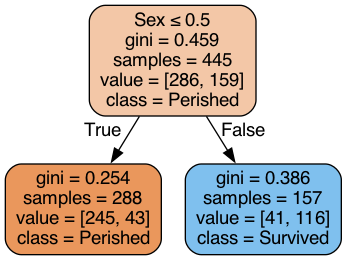

In [9]:
decisionTree = tree.DecisionTreeClassifier()

XTrain, XTest, yTrain, yTest = splitData(["Sex"])
# fit the tree with the traing data
decisionTree = decisionTree.fit(XTrain, yTrain)

# predict with the training data
y_pred_train = decisionTree.predict(XTrain)
# measure accuracy
print('Accuracy on training data = ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

# predict with the test data
y_pred = decisionTree.predict(XTest)
# measure accuracy
print('Accuracy on test data = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

renderTree(decisionTree, ["Sex"])

~76% correct on the test set isn't bad! - sex seems to be a very good indicator of whether someone has survived or not. But let's increase the complexity a bit...

## 1.5 Adding more features

Accuracy on training data=  0.8337078651685393
Accuracy on test data=  0.7600896860986547


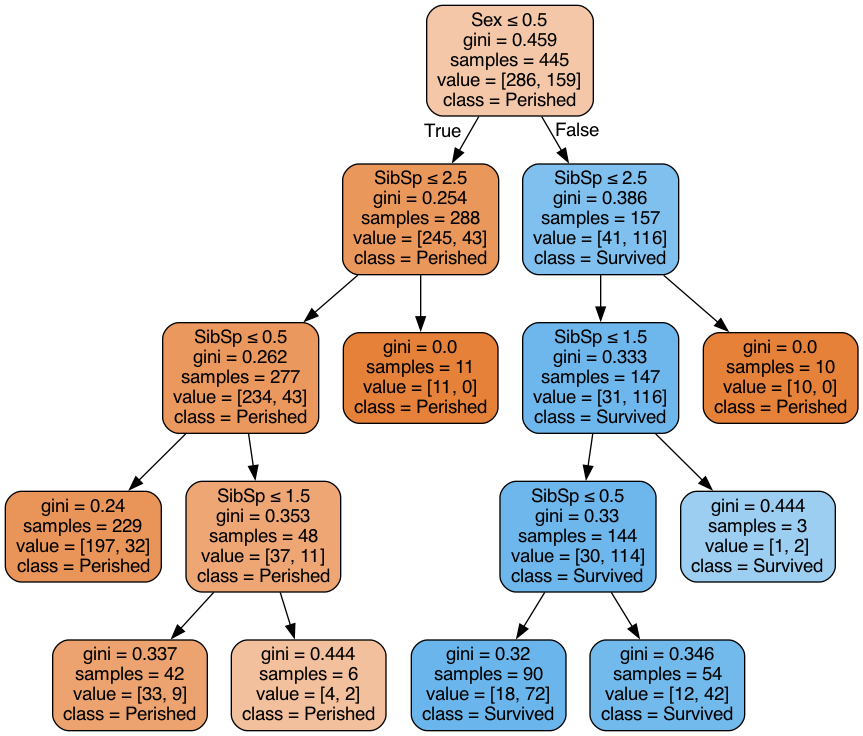

In [10]:
#  train tree on sex and the number of the number of siblings/spouses aboard
used_features = ["Sex", "SibSp"]
XTrain, XTest, yTrain, yTest = splitData(used_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, used_features)

Our accuracy on the training data has gone up, but the accuracy on the test data has gone down. It might be that we are down the road to overfitting... But maybe we just selected the wrong features?

### "Let's just try all of them" (famous last words of the data scientist).

Accuracy on training data=  0.9887640449438202
Accuracy on test data=  0.7488789237668162


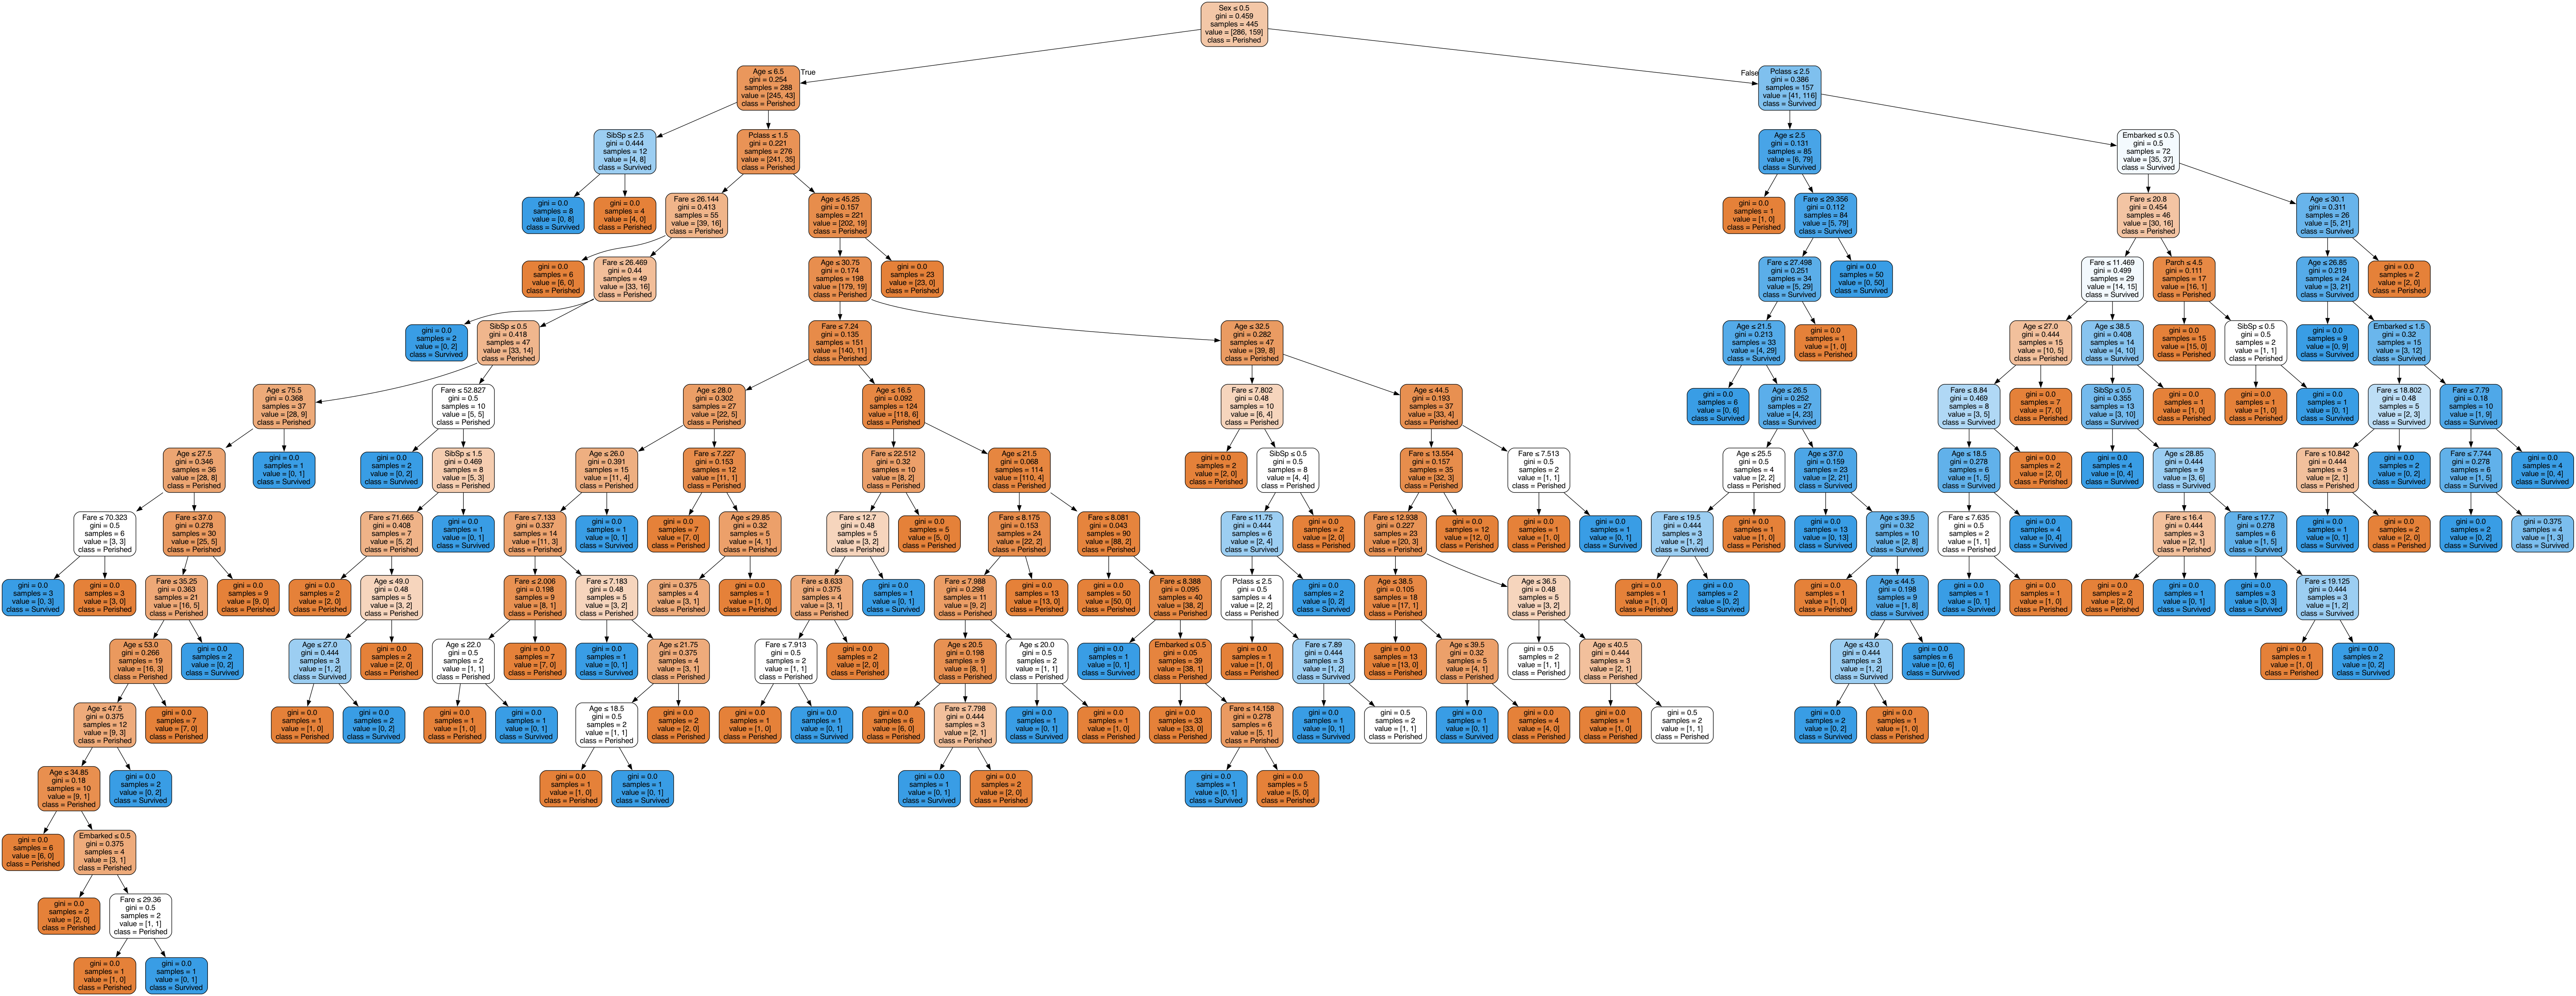

In [11]:
all_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

XTrain, XTest, yTrain, yTest = splitData(all_features)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

If you were not persuaded before, now it should be clear that we are overfitting the data - 98% accuracy on the training data and only ~76% on the test data. Also, in case you didn't notice, we've created a complicated tree that is almost impossible to read.

Decision trees are notorious for overfitting the data. There are two parameters that help us hold the fort against the curse of overfitting:

* **max_depth:** The maximum depth of the tree. If this is not set, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
* **min_samples_split:** The minimum number of samples required to split an internal node: If the value is an integer, then consider `min_samples_split` as the minimum number. If it is float, then `min_samples_split` is a percentage and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split.

Let's try combinations of depth and min split size:

Accuracy on training data=  0.8629213483146068
Accuracy on test data=  0.7937219730941704


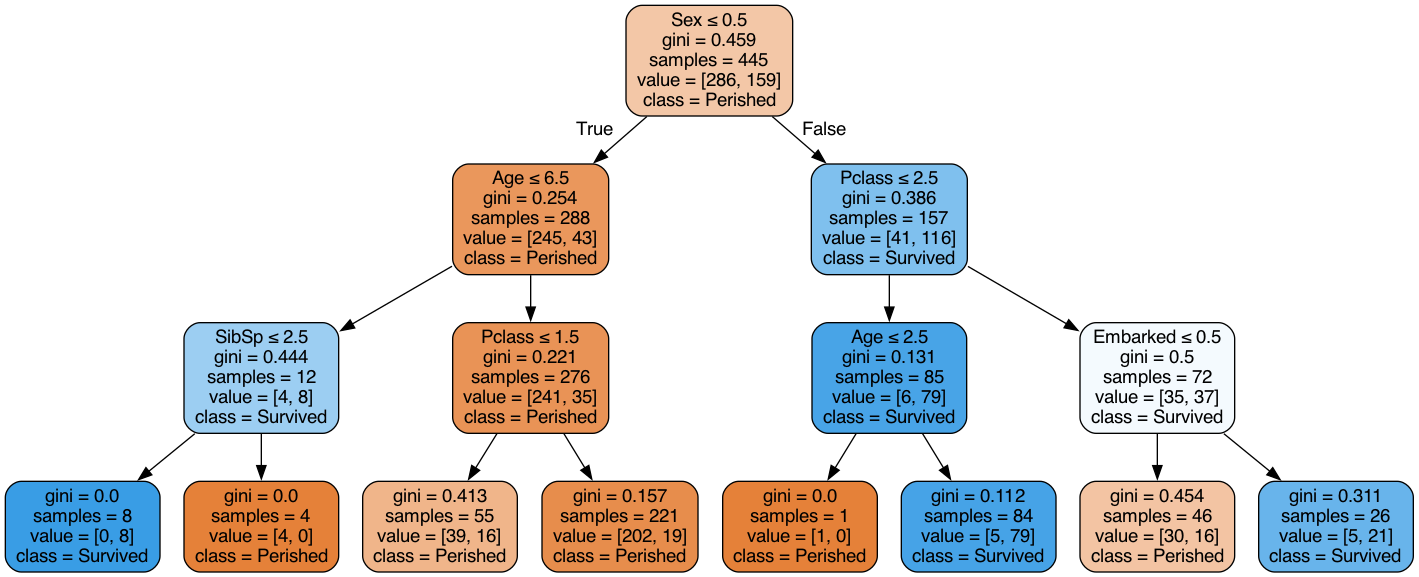

In [12]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.8943820224719101
Accuracy on test data=  0.7757847533632287


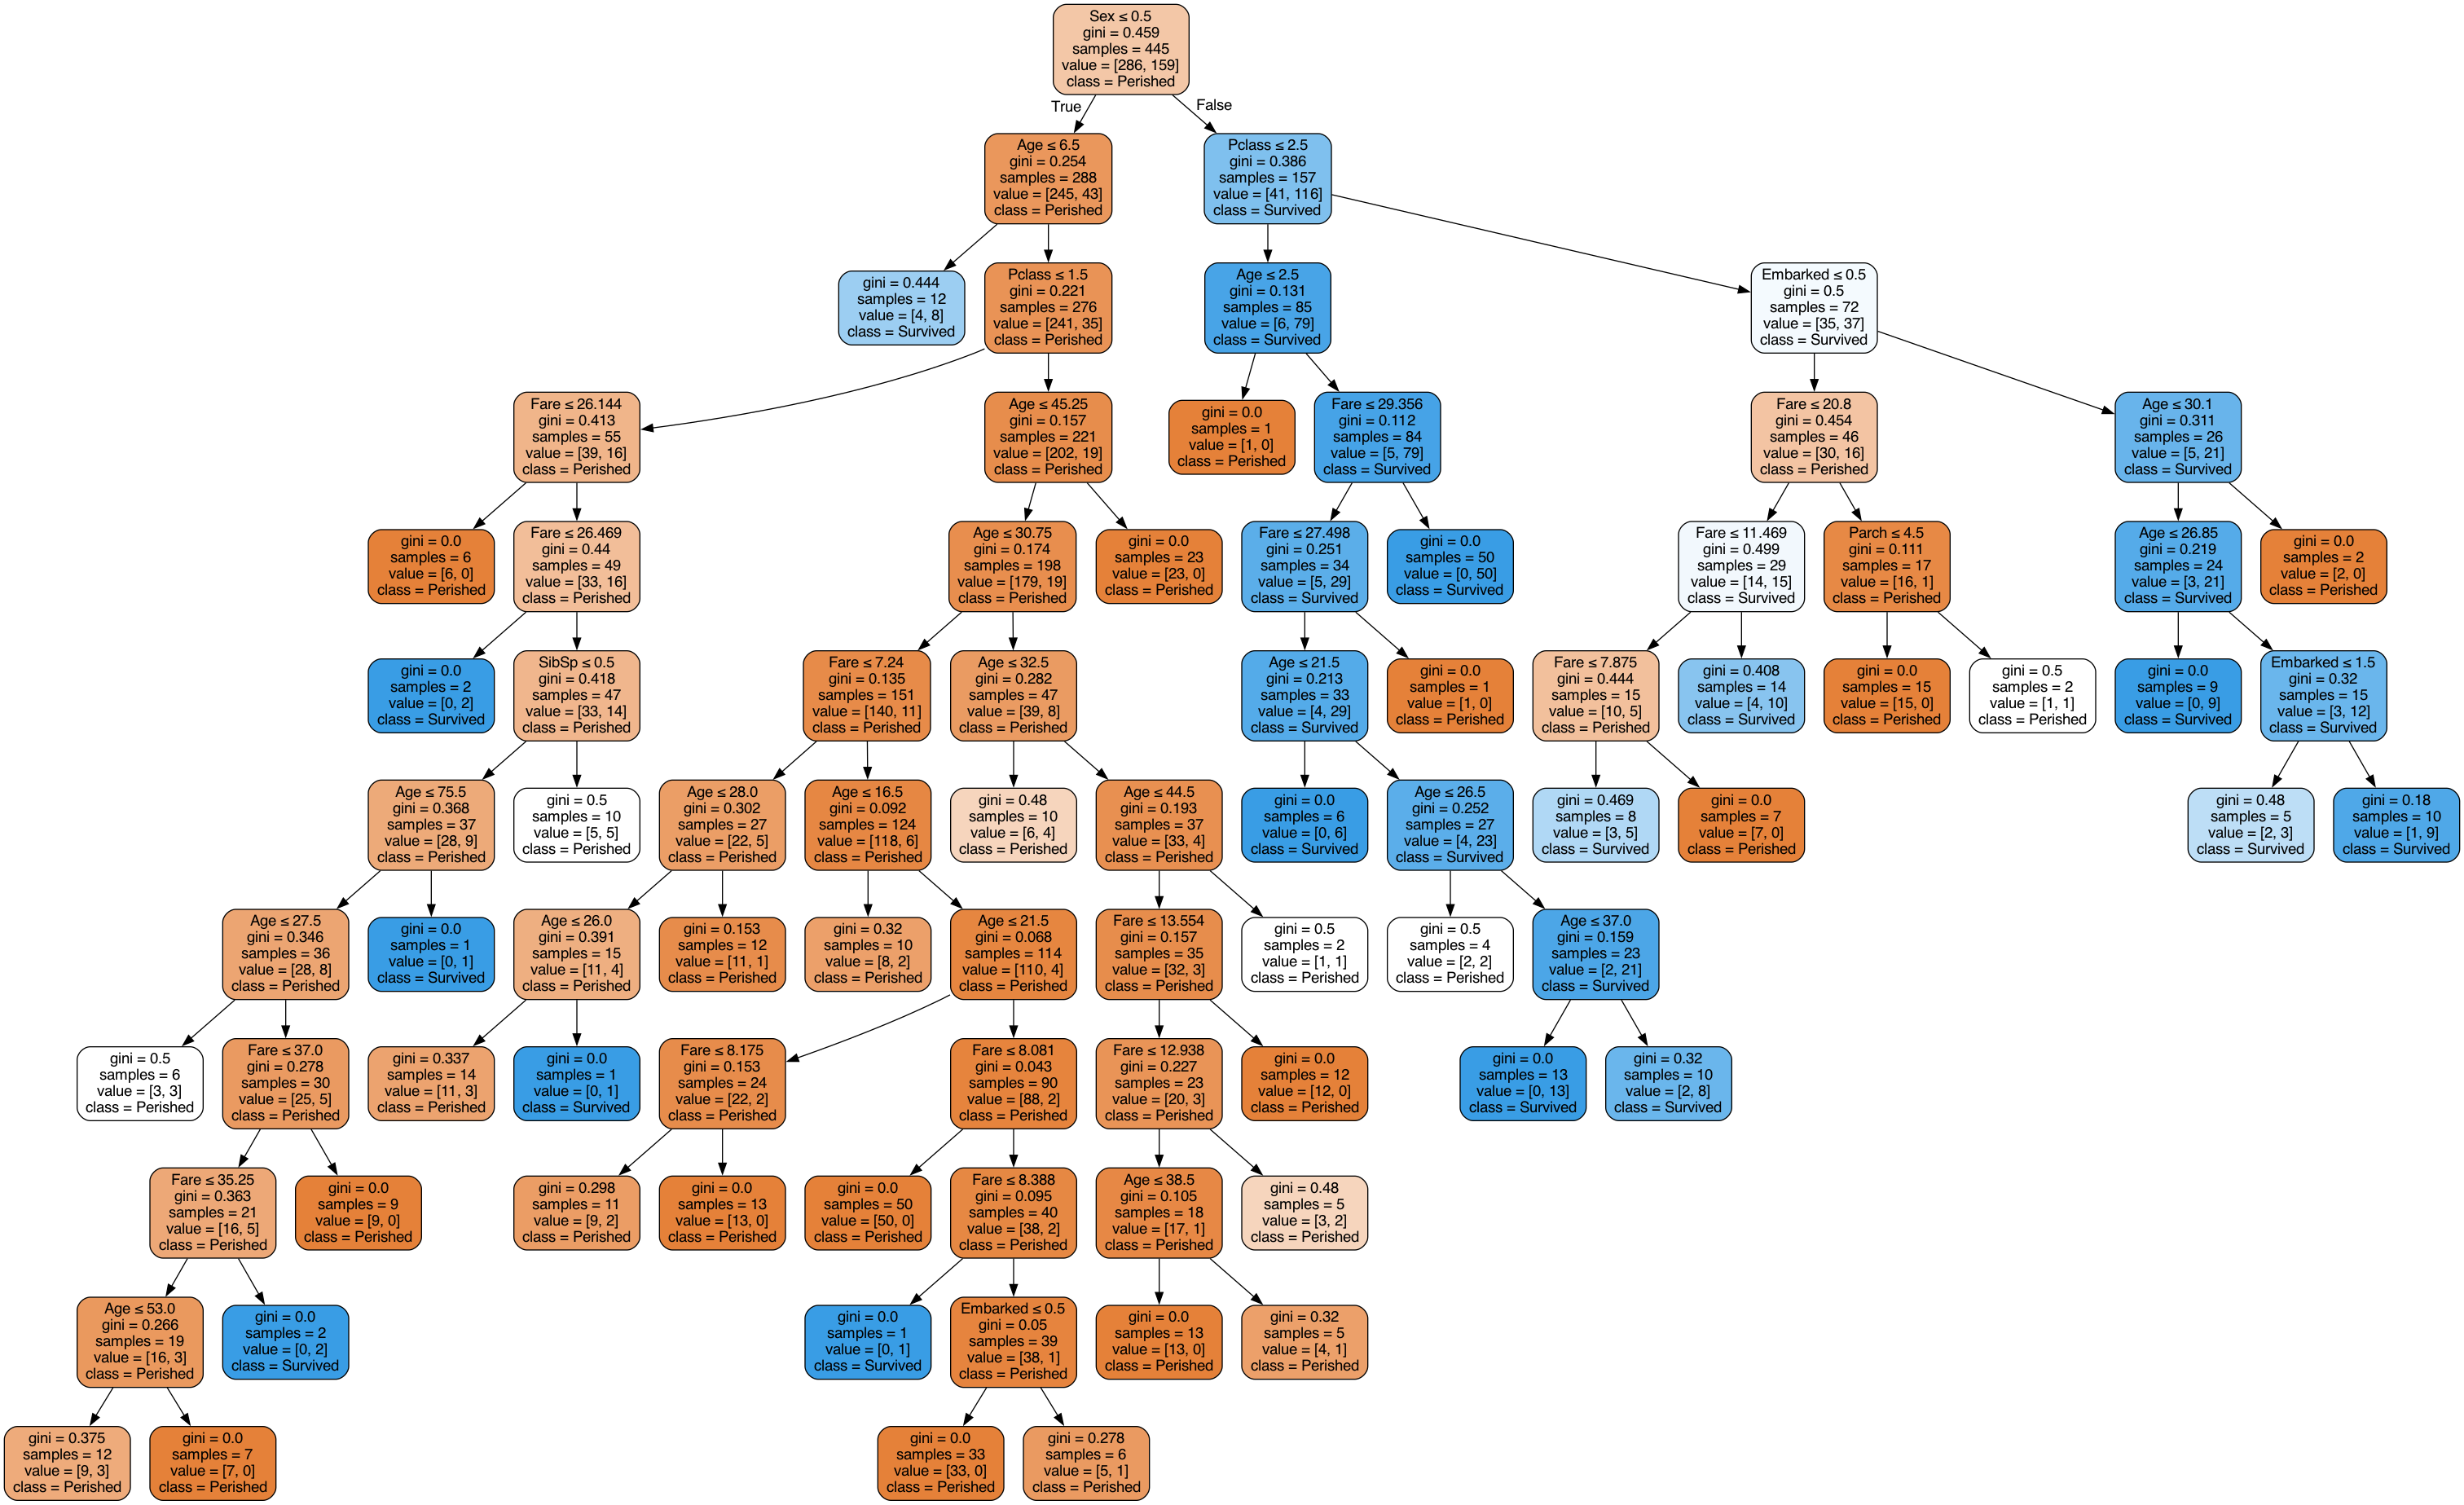

In [13]:
decisionTree = tree.DecisionTreeClassifier(min_samples_split=15)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

Accuracy on training data=  0.8629213483146068
Accuracy on test data=  0.7937219730941704


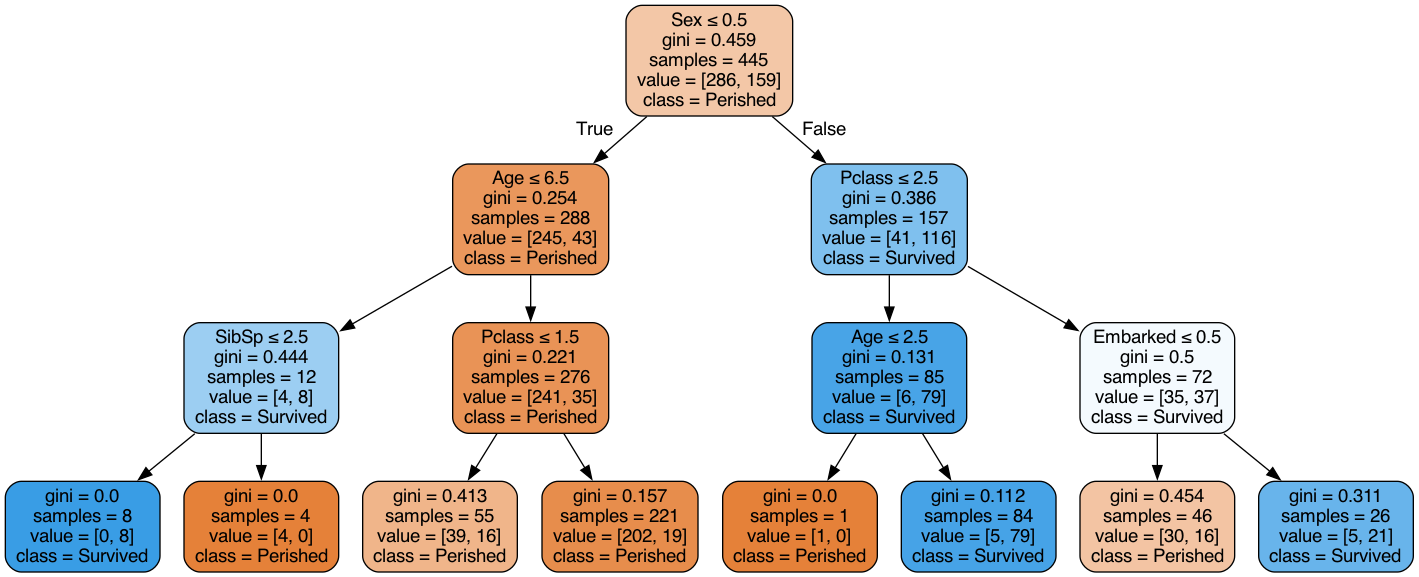

In [14]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3, min_samples_split=10)

decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
renderTree(decisionTree, all_features)

It looks like both, the minimum number of samples for splitting and the maximum depth help with overfitting and we achieve a 79-80% accuracy rate on the test set. That doesn't sound much better than just gender alone, but 4% improvement might be considered a lot in binary classification (depending on the application).

Also, our last model is fairly simple yet quite accurate. The main point seems to be:

 * Sex is the dominant factor at the root of the tree
 * For females, if you're in class 1 or 2 you're almost guaranteed to jump on a boat (and survive)
 * For males, if you were younger than 6.5 years old, you had a chance to survive. 
 * Also note that there are branches that predict the same thing, but with different certainty. For example, in the male / adult category, if you were in "first class", you still were likely to die, but less likely than in second or third. 

# Decision Rules

Let's now define a decision tree a bit more formally.
* A decision rule $r : {X} \to \{\text{true}, \text{false}\}$ is a partition of the feature space into two disjoint regions, e.g.:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_\text{male} = YES \\ \text{false} & \text{if } x_\text{male} \neq NO \end{cases} $$

or another rule with numerical variable

$$ r(x) = \begin{cases}\text{true} & \text{if } x_\text{age} > 9.5 \\ \text{false} & \text{if } x_\text{age} \leq 9.5 \end{cases} $$


* Normally, a rule applies to only one feature or attribute $x_j$ of $x$.
* If $x_j$ is continuous, the rule normally separates inputs $x_j$ into disjoint intervals $-\infty, c], (c, \infty)$.

# Decision Trees: Definition

A decision tree is a (usually binary) tree, where: 

* Each internal node $n$ corresponds to a rule $r_n$

* Each leaf node $l$ contains a prediction $f(x)$

* Given input $x$, we start at the root, apply its rule, follow the edge that corresponds to the outcome, and repeat recursively.

# Decision Regions

Decision trees partition the space of features into regions:
* A decision region $R\subseteq {X}$ is a subset of the feature space defined by the application of a set of rules $r_1, r_2, \ldots, r_m$ <!--and their values $v_1, v_2, \ldots, v_m \in \{\text{true}, \text{false}\}$, i.e.:-->

$$ R = \{x \in {X} \mid r_1(x) = v_1 \text{ and } \ldots \text{ and } r_m(x) = v_m \} $$

* For example, a decision region in the Titanic (first and simple) tree is:

$$ R = \{x \in {X} \mid x_\text{male} = YES \text{ and } x_\text{age} > 9.5 \} $$

<center>
<img src="img/titanic_tree.png" width="500">
</center>


We can illustrate decision regions via this figure from the textbook (Hastie et al.)

<center><img width=50% src="img/decision_tree.png"></center>

The illustrations are as follows:
* Top right: regions that can be represented by a tree
* Bottom left: tree generating the top right regions
* Bottom right: function values assigned to the regions
* Top left: regions that cannot be represented by a tree.

# Decision Trees and Regions

A decision tree can be written as a model $f : {X} \to {Y}$ of the form
$$ f(x) = \sum_{R} y_R \mathbb{I}\{x \in R\}. $$
* The $\mathbb{I}\{\cdot\}$ is an indicator function (one if $\{\cdot\}$ is true, else zero) and values $y_R \in \mathcal{Y}$ are the outputs for that region.

* We sum over decision regions ${R}$.
* The rules defining the regions ${R}$ can be organized into a tree.

# Pros and Cons of Decision Trees

Decision trees are important models in machine learning
* They are highly interpretable (both in terms of rules and visualization).
* Require little data preparation (no rescaling, handle continuous and discrete features).

Their main disadvantages are that:
* If they stay small and interpretable, they are not as powerful.
* If they are large, they easily overfit (thus, have high variance) and are hard to regularize due to their objective function.

# Part 2: Learning Decision Trees

We saw how decision trees are represented. How do we now learn them from data?


# Learning Decision Trees

At a high level, decision trees are grown by adding nodes one at a time.

```python
def build_tree():
    while tree.is_complete() is False:
        leaf, leaf_data = tree.get_leaf()
        new_rule = create_rule(leaf_data)
        tree.append_rule(leaf, new_rule)
```

Most often, we build the tree until it reaches a maximum number of nodes. The crux of the algorithm is in `create_rule`.

# Learning New Decision Rules

<!-- What is the set of possible rules that `create_rule` can add to the tree?  -->

When $x$ has continuous features, the rules have the following form:

$$ r(x) = \begin{cases}\text{true} & \text{if } x_j \leq t \\ \text{false} & \text{if } x_j > t \end{cases} $$

for a feature index $j$ and threshold $t \in \mathbb{R}$.

When $x$ has categorical features, rules may have the following form:
$$ r(x) = \begin{cases}\text{true} & \text{if } x_j = t_k \\ \text{false} & \text{if } x_j \neq t_k \end{cases} $$
for a feature index $j$ and possible value $t_k$ for $x_j$.

# Learning New Decision Rules

How does the `create_rule` function choose new rule $r$?

We add to the leaf a new rule $r : {X} \to \{T, F\}$ that minimizes a loss:
$$ \min_{r} \left( L(\text{left subtree of $r$}) +  L(\text{right subtree of $r$})\right) $$

where $L$ is a loss function over a subset of the data flagged by the rule.

<center>
<img src="img/titanic_tree.png" width="500">
</center>


We add to the leaf a new rule $r : \mathcal{X} \to \{T, F\}$ that minimizes a loss:
$$ \min_{r \in \mathcal{U}} \left( \underbrace{L(\{(x, y) \in \mathcal{D}_R \mid r(x) = \text{T}\})}_\text{left subtree} +  \underbrace{L(\{(x, y) \in \mathcal{D}_R \mid r(x) = \text{F}\}}_\text{right subtree})\right) $$

where $L$ is a loss function over a subset of the data flagged by the rule and $\mathcal{U}$ is the set of possible rules.

# Objectives for Trees: Classification

Let's say that $R$ is a leaf region and ${D}_R = \{(x^{(i)}, y^{(i)}\mid x^{(i)} \in R \}$ is the data for $R$.

In classification, we want leaves to all have the same class:
$$ L({D}_R) = \frac{1}{|{D}_R|} \sum_{(x, y) \in {D}_R} \mathbb{I} \left\{ y \neq \texttt{most-common-y}({D}_R) \right\}. $$

At a leaf node with region $R$, we predict $\texttt{most-common-y}({D}_R)$, the most common class $y$ in the data.

There are a number of ways to understand this objective.
$$ L({D}_R) = \frac{1}{|{D}_R|} \sum_{(x, y) \in {D}_R} \mathbb{I} \left\{ y \neq \texttt{most-common-y}({D}_R) \right\}. $$

* The above loss measures the resulting misclassification error.

* It also measures the purity of the leaves.

* Optimal leaves all feature the same class (hence separate the classes well), and are maximally pure/accurate.

Other losses that can be used include the entropy or the Gini index (that's what we used in the Titanic example). These all optimize for a split in which different classes do not mix.

# Objectives for Trees: Regression

In regression, we minimize the L2 error between the data and the single best prediction we can make on this data:

$$ L({D_R}) = \sum_{(x, y) \in {D_R}} \left( y - \texttt{average-y}({D_R}) \right)^2. $$

<!-- If this was a leaf node, we would predict $\texttt{average-y}(\mathcal{D_R})$, the average $y$ in the data. The above loss measures the resulting squared error. -->

This yields the following optimization problem for selecting a rule:
$$ \min_{r \in \mathcal{U}} \left[ \sum_{(x, y) \in \mathcal{D}_R \,\mid\, r(x) = \text{T}} \left( y - p_\text{true}(r) \right)^2 +  \sum_{(x, y) \in \mathcal{D}_R \,\mid\, r(x) = \text{F}} \left( y - p_\text{false}(r) \right)^2 \right] $$

where $p_\text{true}(r) = \texttt{average-y}(\{(x, y) \mid (x, y) \in \mathcal{D}_R \text{ and } r(x) = \text{true}\})$ and $p_\text{false}(r) = \texttt{average-y}(\{(x, y) \mid (x, y) \in \mathcal{D}_R \text{ and } r(x) = \text{false}\})$ are the average predictions on each part of the data split.

# Other Practical Considerations

A few additional comments on the above training procedure;
* Nodes are added to until tree reaches a maximum depth or the leaves can't be split anymore.
* In practice trees are also often pruned in order to reduce overfitting.
* There exist alternative algorithms, including ID3, C4.5, C5.0. Check textbook for details!

# Algorithm: Classification and Regression Trees (CART)

* __Type__: Supervised learning (regression and classification).
* __Model family__: Decision trees.
* __Objective function__: Squared error, misclassification error, Gini index, etc.
* __Optimizer__: Greedy addition of rules (sometimes followed by pruning)

# Part 3: Bagging

Next, we are going to see a general technique to improve the performance of machine learning algorithms.

We will then apply it to decision trees to define an improved algorithm.

## POLL:

<img src="img/wooclap.png" alt="drawing" width="500"/>

### Without cheating, respond: Which year was the Titanic movie out?

# Review: Overfitting

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (e.g. a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect predictions outside this dataset, and doesn't generalize.

Recall this example, in which we take random samples around a true function.

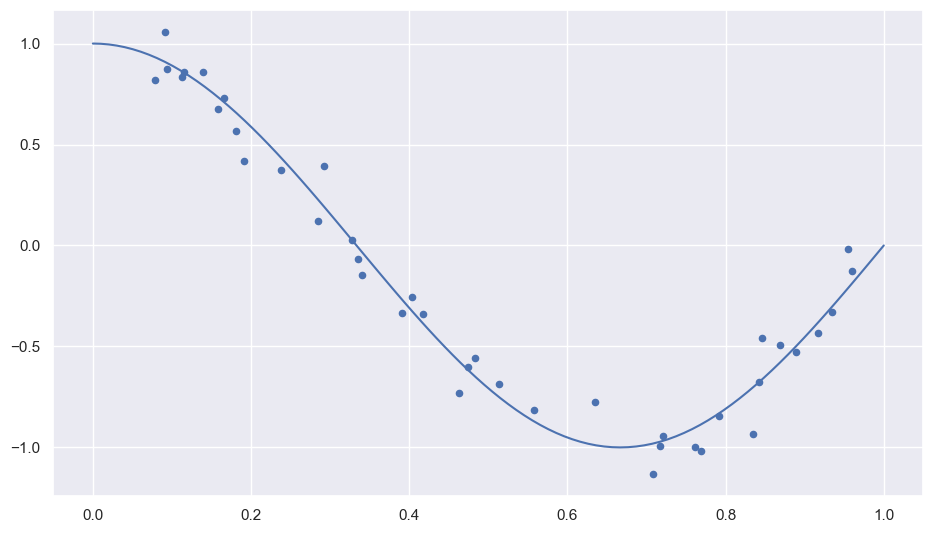

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def true_fn(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(4400)
n_samples = 40
X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

# Fitting High-Degree Polynomials

Let's see what happens if we fit a high degree polynomial to random samples of 20 points from this dataset.

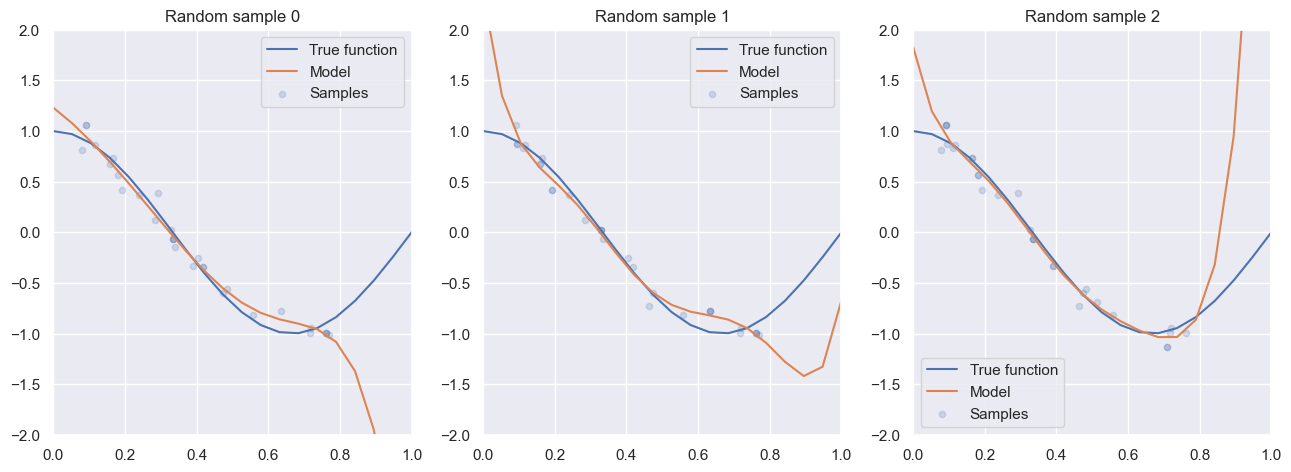

In [16]:
n_plots, X_line = 3, np.linspace(0,1,20)
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, 30, size=(30,))
    X_random, y_random = X[random_idx], y[random_idx]

    polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_random[:, np.newaxis], y_random)

    ax.plot(X_line, true_fn(X_line), label="True function")    
    ax.plot(X_line, pipeline.predict(X_line[:, np.newaxis]), label="Model")
    ax.scatter(X_random, y_random, edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title('Random sample %d' % i)

# High-Variance Models

Each small subset of the data that we train on results is a very different model.

An algorithm that has a tendency to overfit is also called *high-variance*, because it outputs a predictive model that varies a lot if we slightly perturb the dataset.

# Bagging: Bootstrap Aggregation

The idea of *bagging* is to reduce model variance by averaging many models trained on random subsets of the data.

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = Model().fit(X_i, y_i)
    ensemble.append(model)

# output average prediction at test time:
y_test = ensemble.average_prediction(x_test)
```
The data samples are taken with replacement and known as bootstrap samples.

<center>
<img src="img/bagging.png" alt="drawing" width="500"/>
    </center>

# Bagged Polynomial Regression

Let's apply bagging to our polynomial regression problem.

We are going to train a large number of polynomial regressions on random subsets of the dataset of points that we created earlier.

We start by training an ensemble of bagged models.

In [17]:
n_models, n_subset = 10000, 30
ensemble, Xs, ys = [], [], []
for i in range(n_models):
    # take a random subset of the data
    random_idx = np.random.randint(0, 30, size=(n_subset,))
    X_random, y_random = X[random_idx], y[random_idx]

    # train a polynomial regression model
    polynomial_features = PolynomialFeatures(degree=6, include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X_random[:, np.newaxis], y_random)

    # add it to our set of bagged models
    ensemble += [pipeline]
    Xs += [X_random]
    ys += [y_random]

Let's visualize the prediction of the bagged model on each random dataset sample and compare to predictions from an un-bagged models.

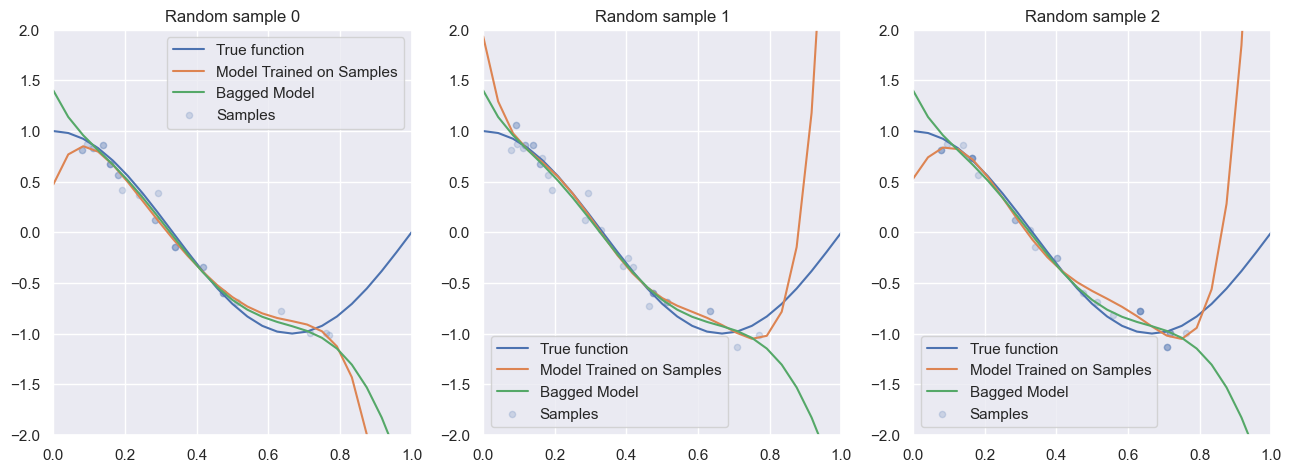

In [18]:
n_plots, X_line = 3, np.linspace(0,1,25)
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)

    # generate average predictions
    y_lines = np.zeros((25, n_models))
    for j, model in enumerate(ensemble):
        y_lines[:, j] = model.predict(X_line[:, np.newaxis])
    y_line = y_lines.mean(axis=1)

    # visualize them
    ax.plot(X_line, true_fn(X_line), label="True function")    
    ax.plot(X_line, y_lines[:,i], label="Model Trained on Samples")
    ax.plot(X_line, y_line, label="Bagged Model")
    ax.scatter(Xs[i], ys[i], edgecolor='b', s=20, label="Samples", alpha=0.2)
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title('Random sample %d' % i)

# Extensions of Bagging

There exist a few closely related techniques to bagging.
* **Pasting** is when samples are taken without replacement.
* **Random features** are when we randomly sample the features.
* **Random patching** is when we do both of the above.

# Summary: Bagging

### Pros

+ Bagging is a general technique that can be used with high-variance ML algorithms (e.g. decision trees).
+ It's difficult to overfit on the training dataset. Why?
+ We have a "natural" validation set. Since we do sampling with replacement, some data points are left out of each bootstrap sample. These left-out data points are called Out-of-Bag (OOB) samples. By aggregating predictions across all OOB samples, an OOB error estimate is computed.

### Cons

+ The major drawback of bagging (and other ensemble methods) is that the averaged model is no longer easily or directly interpretable - i.e. one can no longer trace the "logic" of an output through a series of decisions based on predictor values.

+ Moreover, in practice, if we use decision tree as a base model, then the ensembles of trees in bagging tend to be highly correlated. Suppose we have an extremely strong predictor, $x_j$, in the training set amongst moderate predictors. Then, the DT learning algorithm ensures that most of the models in the ensemble will choose to split on $x_j$ in early iterations. That is, each tree in the ensemble is identically distributed, with the expected output of the averaged model the same as the expected output of any one of the trees.

# Part 4: Random Forests

Next, let's see how bagging can be applied to decision trees. This will also provide us with a new algorithm.


# Classification Dataset: Iris Flowers

Let's now look at the performance of decision trees on a new dataset, Iris flowers.

It's a classical dataset originally published by [R. A. Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936. Nowadays, it's widely used for demonstrating machine learning algorithms.

In [33]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.tree import plot_tree

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)

print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [26]:
# print part of the dataset
iris_X, iris_y = iris.data, iris.target
pd.concat([iris_X, iris_y], axis=1).head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

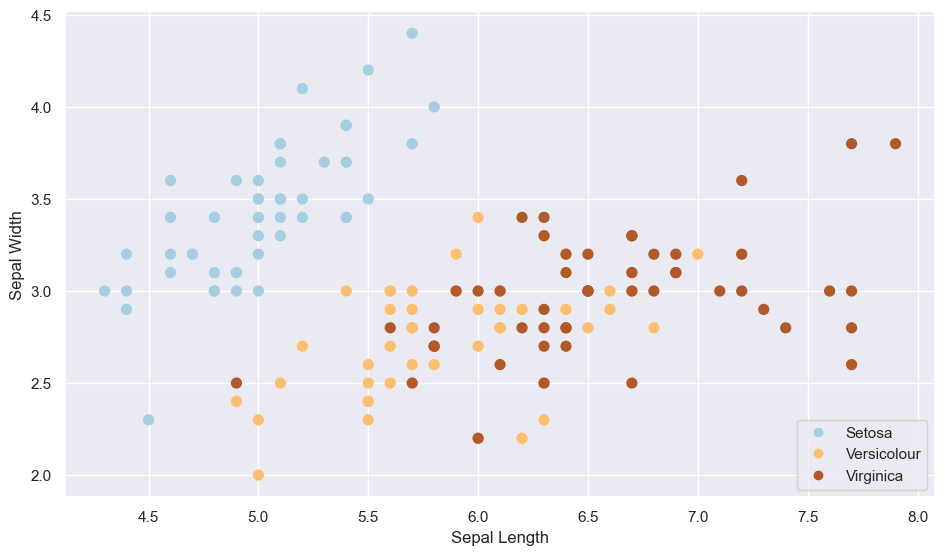

In [27]:
# Plot also the training points
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, s=50, cmap=plt.cm.Paired)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Versicolour', 'Virginica', 'Query'], loc='lower right')

# Decision Trees on the Iris Dataset

Let's now consider what happens when we train a decision tree on the Iris flower dataset.

The code below will be used to visualize predictions from decision trees on this dataset.

In [34]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

def make_grid(X):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
    y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    return xx, yy, x_min, x_max, y_min, y_max

def make_2d_preds(clf, X):
    xx, yy, x_min, x_max, y_min, y_max = make_grid(X)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

def make_2d_plot(ax, Z, X, y):
    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    xx, yy, x_min, x_max, y_min, y_max = make_grid(X)

    # Put the result into a color plot
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k', s=50)
    ax.set_xlabel('Sepal Length')
    ax.set_ylabel('Sepal Width')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())    

We may now train and visualize a decision tree on this dataset.

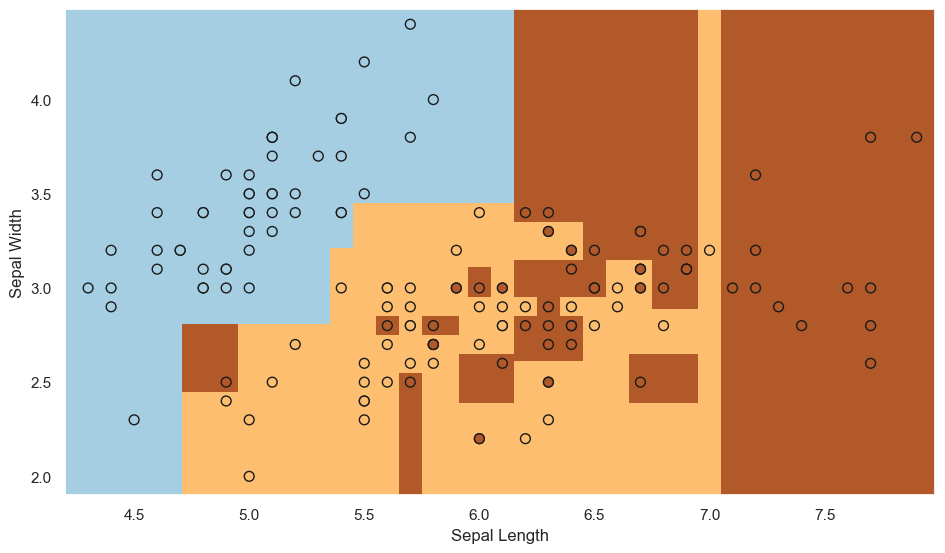

In [35]:
# Train a Decision Tree Model
ax = plt.gca()
X = iris_X.iloc[:,:2]
clf2 = DecisionTreeClassifier()
clf2.fit(X, iris_y)
Z = make_2d_preds(clf2, X)
make_2d_plot(ax, Z, X, iris_y)

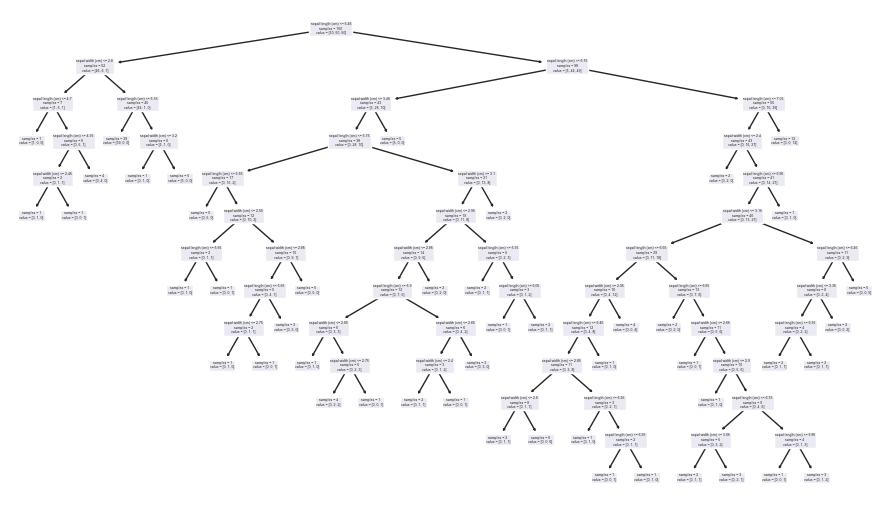

In [36]:
plot_tree(clf2, feature_names=iris.feature_names[:2], impurity=False)
print('')

# Two Problems With Decision Trees

We see two problems with the output of the decision tree on the Iris dataset:
* The decision boundary between the two classes is very non-smooth and "blocky".
* The decision tree overfits the data and the decision regions are highly fragmented.

# High-Variance Decision Trees

When the trees have sufficiently high depth, they can quickly overfit the data.

Recall that this is called the *high variance* problem, because small perturbations of the data lead to large changes in model predictions.

Consider the performance of a decision tree classifier on 3 random subsets of the data.

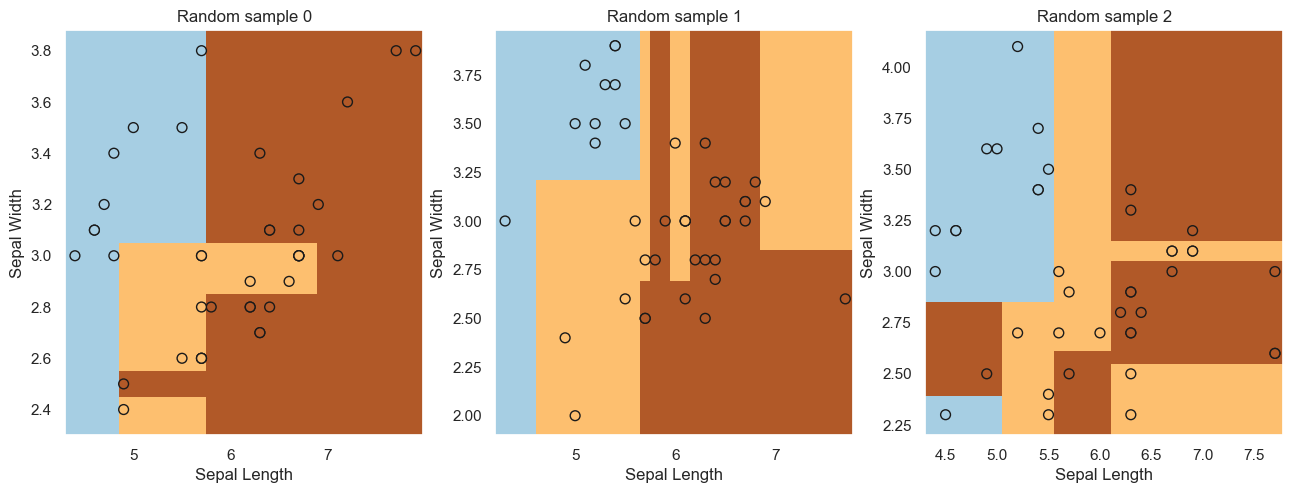

In [37]:
n_plots, n_flowers, n_samples = 3, iris_X.shape[0], 40
plt.figure(figsize=(14, 5))
for i in range(n_plots):
    ax = plt.subplot(1, n_plots, i + 1)
    random_idx = np.random.randint(0, n_flowers, size=(n_samples,))
    X_random, y_random = iris_X.iloc[random_idx, :2], iris_y[random_idx]

    clf = DecisionTreeClassifier()
    clf.fit(X_random, y_random)
    Z = make_2d_preds(clf, X_random)
    make_2d_plot(ax, Z, X_random, y_random)
    ax.set_title('Random sample %d' % i)

# Random Forests

In order to reduce the variance of the basic decision tree, we apply bagging -- the variance reduction technique that we have seen earlier.

Recall, that we said one of the issues with bagging in decision trees is the correlated trees. Random Forests address this problem by adding extra randomness to tree construction. Like Bagging, Random Forest trains multiple trees on bootstrap samples. However, instead of using all features for each split, only a random subset of features is considered (controlled by `max_features`). This additional randomness makes the trees less correlated, improving generalization.

Instantiating our definition of bagging with decision trees, we obtain the following pseudocode definition of random forests:

```python
for i in range(n_models):
    # collect data samples and fit models
    X_i, y_i = sample_with_replacement(X, y, n_samples)
    model = DecisionTree(max_features=m).fit(X_i, y_i)
    random_forest.append(model)

# output average prediction at test time:
y_test = random_forest.average_prediction(y_test)
```

We may implement random forests in python as follows:

In [38]:
np.random.seed(1000)
n_models, n_flowers, n_subset = 300, iris_X.shape[0], 10
random_forest = []
for i in range(n_models):
    # sample the data with replacement
    random_idx = np.random.randint(0, n_flowers, size=(n_subset,))
    X_random, y_random = iris_X.iloc[random_idx, :2], iris_y[random_idx]

    # train a decision tree model
    clf = DecisionTreeClassifier(max_features=2)
    clf.fit(X_random, y_random)

    # append it to our ensemble
    random_forest += [clf]

# RF on the Flower Dataset

Consider now what happens when we deploy random forests on the same dataset as before.

Now, each prediction is the average on the set of bagged decision trees.

NB: For demo purposes I included both features so in principle we have a bagging here.

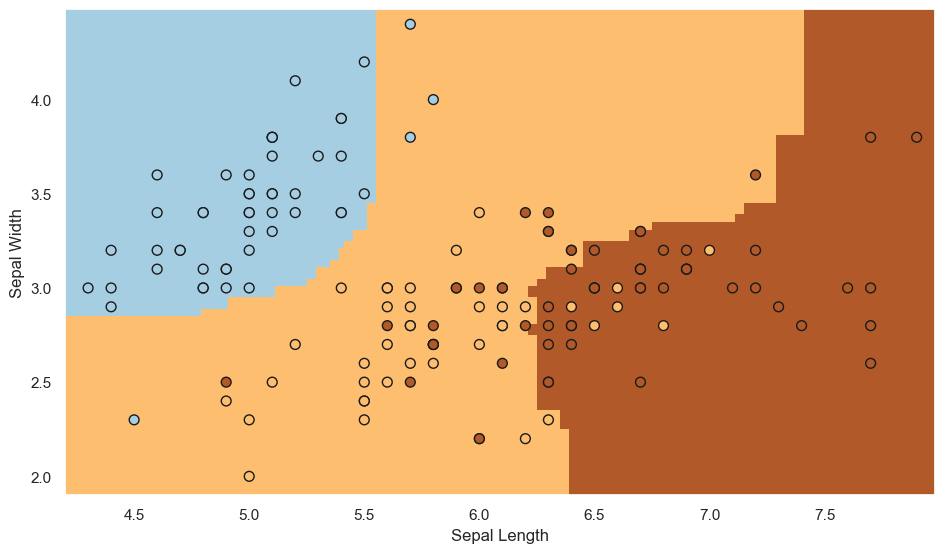

In [39]:
# Visualize predictions from bagging
ax = plt.gca()

# compute average predictions from all the models in the ensemble
X_all, y_all = iris_X.iloc[:,:2], iris_y
Z_list = []
for clf in random_forest:
    Z_clf = make_2d_preds(clf, X_all)
    Z_list += [Z_clf]
Z_avg = np.stack(Z_list, axis=2).mean(axis=2)

# visualize predictions
make_2d_plot(ax, np.rint(Z_avg), X_all, y_all)

The boundaries are much more smooth and well-behaved.

### Hyperparameters of Random Forests

Random forest models have multiple hyper-parameters to tune:

+ the number of predictors $m$ to randomly select at each split (typically, $m=\sqrt p$), where $p$ is the number of predictors) (`max_features` in sklearn)
+ the total number of trees in the ensemble (`n_estimators` in sklearn)
+ the minimum leaf node size / max depth / minimum samples split (same as decision trees).

Most likely, you want to do cross-validation for identifying the first two hyperparameters and for the third one: in theory, each tree in the random forest is full, but in practice this can be computationally expensive (and adds redundancies to the model), thus, imposing a minimum node size is not unusual.

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#change this line to load the whole dataset
#X_all, y_all = iris_X, iris_y
X_all, y_all = iris_X.iloc[:,:2], iris_y

forest =  RandomForestClassifier(bootstrap=True, max_features=2, n_estimators=300, min_samples_leaf=1, min_samples_split=5, random_state=42)

trained_forest = forest.fit(X_all, y_all)

y_pred_train = trained_forest.predict(X_all)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = iris_y, y_pred = y_pred_train))

Accuracy on training data=  0.88


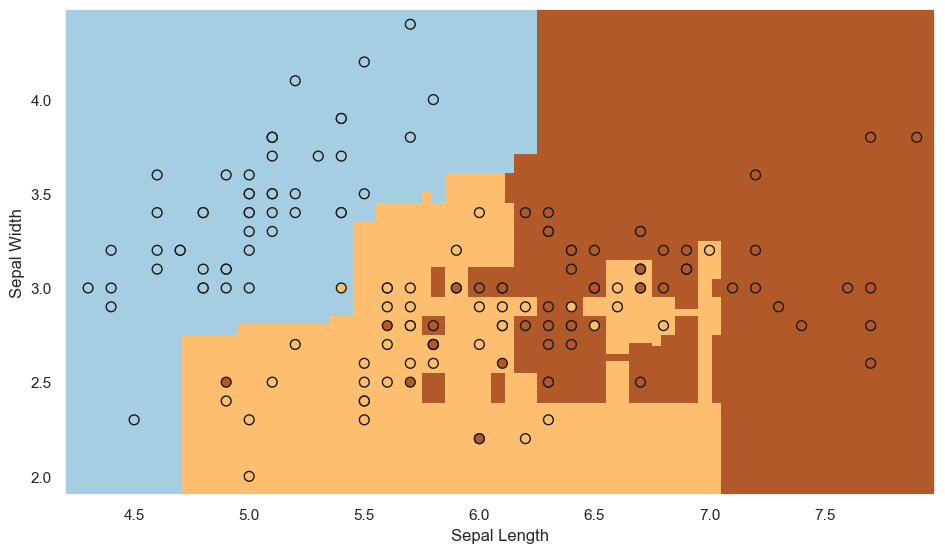

In [41]:
# Visualize predictions from RF
ax = plt.gca()

# compute predictions from all the models in the ensemble
X_all, y_all = iris_X.iloc[:,:2], iris_y
Z_clf1 = make_2d_preds(forest, X_all)

# visualize predictions
make_2d_plot(ax, Z_clf1, X_all, y_all)

### Variable importance: Why we ❤️ random forests 

For bagged/RF regression trees, we record the total amount that the RSS (or other criterion) is decreased due to splits over a given predictor, averaged over all trees. A large value indicates an important predictor.

Similarly, for bagged/RF classification trees, we add up the total amount that the metric (used for splitting e.g. Entropy) is improved by splits over a given predictor, averaged over all trees.

             Feature  Importance
0  sepal length (cm)   69.598319
1   sepal width (cm)   30.401681


<Axes: xlabel='Feature'>

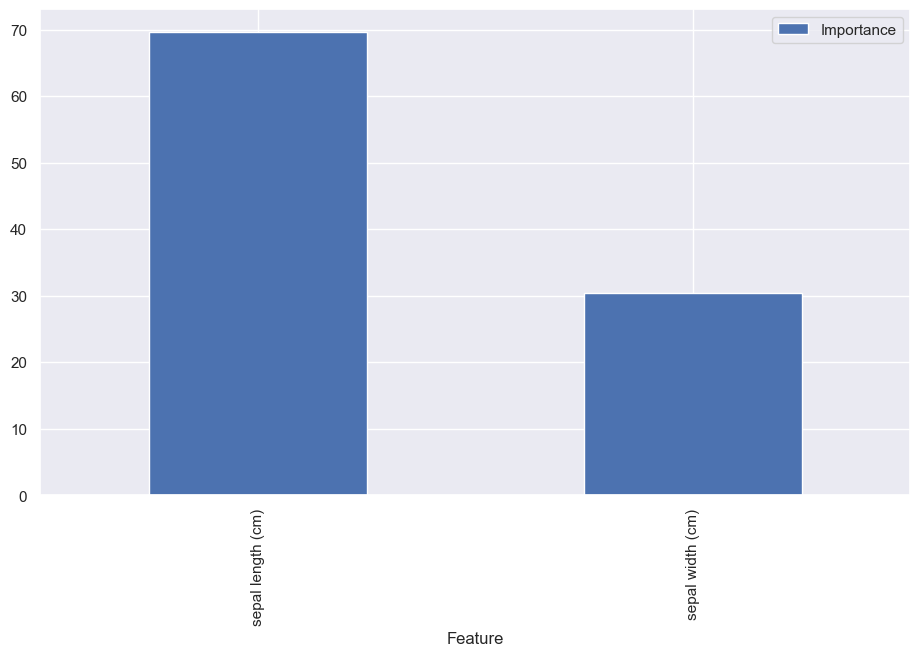

In [42]:
imp = {'Feature':forest.feature_names_in_,'Importance':forest.feature_importances_*100}
d_imp = pd.DataFrame(imp).sort_values(by='Importance', ascending=False)
print(d_imp)

d_imp.plot.bar(x='Feature', y='Importance')

# Algorithm: Random Forests

* __Type__: Supervised learning (regression and classification).
* __Model family__: Bagged decision trees with extra randomness
* __Objective function__: Squared error, misclassification error, Gini index, etc.
* __Optimizer__: Greedy addition of rules, followed by pruning.

# Pros and Cons of Random Forests

Random forests remain a popular machine learning algorithm:
* They require little data preparation (no rescaling, handle continuous and discrete features, work well for classification and regression).
* They are often quite accurate and considered a good baseline model.

Their main disadvantages are that:
* They are not interpretable anymore.
* They do not work well with non-tabular data (text, images, audio).